# Causal Discovery to Causal Inference
Yongwoo Jeong 

GS ITM

In [2]:
import os
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

import graphviz
import lingam
from lingam.utils import make_dot
from graphs_analysis import make_graph, get_causal_model
from graphs_analysis import get_optimal_intervention, get_label_processing
from graphs_analysis import get_total_effect, get_intervention_effect, get_bootstrapping_prediction

import plotly
import plotly.graph_objects as go
from dowhy import CausalModel

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

### Dataset was collected from Yahoo Finance.

crude oil stock code: CL=F

anderson stock code : ANDE

natural gas stock code: NG=F

constellation stock code: STZ

Question: what about Heineken? : HEINY
<br>
Did they suffer or not during the Ukrainian War?

In [3]:
df = pd.read_csv("ukraine_war_effect.csv")

In [4]:
df

,datetime,crude_oil,anderson,natural_gas,constellation,usd
0,2021-12-31,75.209999,38.574017,3.730,249.350586,95.669998
1,2022-01-03,76.080002,39.102158,3.815,251.188660,96.239998
2,2022-01-04,76.989998,39.291489,3.717,252.957169,96.290001
3,2022-01-05,77.849998,38.922791,3.882,251.725159,96.190002
4,2022-01-06,79.459999,39.062298,3.812,243.210464,96.250000
...,...,...,...,...,...,...
111,2022-06-13,120.930000,35.820000,8.609,230.029999,104.150002
112,2022-06-14,118.930000,36.380001,7.189,231.500000,105.080002
113,2022-06-15,115.309998,36.619999,7.420,230.580002,105.519997
114,2022-06-16,117.589996,35.380001,7.464,225.770004,105.160004


In [5]:
X = df[['crude_oil', 'anderson', 'natural_gas', 'constellation', 'usd']]

### causal discovery model

In [6]:
model = get_causal_model()
model.fit(X)

In [7]:
labels, df_inference = get_label_processing(X)

dag = make_graph(model.adjacency_matrix_, labels)

### This is what we found from the dataset.

The causal path is shown in the DAG

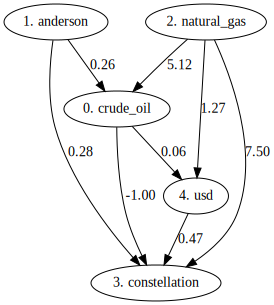

In [8]:
dag

In [9]:
labels

['0. crude_oil', '1. anderson', '2. natural_gas', '3. constellation', '4. usd']

### crude oil price impacting on constellation
Remember this. We will use this for inference later

In [11]:
# crude oil -> constellation
get_total_effect(model, X, cause_index=0, result_index=3)

total effect: -0.972


In [12]:
# natural gas -> crude oil
get_total_effect(model, X, cause_index=2, result_index=0)

total effect: 5.148


In [13]:
# natural gas -> constellation
get_total_effect(model, X, cause_index=2, result_index=3)

total effect: 3.133


### intervention effect

What if there is no connection to the target except some intervention?

What will make more effect on the target?

In [14]:
intervention_data = get_intervention_effect(model, X, target_index=3)

### Remove all incoming arrows to the interesting interventions..

e.g. for crude_oil as intervention, we remove anderson -> crude_oil and natural_gas -> crude_oil 
<br>
but we keep natural_gas -> constellation and anderson -> constellation

In [15]:
intervention_data["intervention_effect"]

,feature,effect_plus,effect_minus
0,crude_oil,11.854465,11.854465
1,anderson,0.158525,0.158525
2,natural_gas,5.330005,5.330005
3,constellation,0.000000,0.000000
4,usd,1.448175,1.448175


In [16]:
intervention_data["max_intervention_element_name"]

'crude_oil'

In [17]:
intervention_data["reg_model"]

LassoCV(cv=7, random_state=0)

In [18]:
intervention_data["causal_effect"]

In [20]:
get_optimal_intervention(X, intervention_data, intervention_index=0, target_index=3, target_value=100)

### Let's use bootstrapping to analyze this further.

In [21]:
boostrapping_result = get_bootstrapping_prediction(X, cause_index=2, target_index=3, n_sampling=100, min_causal_effect=0.01)

In [22]:
boostrapping_result["from-to-df"]

,from,to,effect,probability
0,natural_gas,crude_oil,5.147973,0.86
1,usd,constellation,0.530123,0.79
2,natural_gas,constellation,3.133494,0.77
3,crude_oil,constellation,-0.926805,0.75
4,crude_oil,usd,0.059022,0.75
5,natural_gas,usd,1.600620,0.75
6,usd,crude_oil,2.985867,0.25
7,usd,natural_gas,0.494628,0.25
8,constellation,natural_gas,0.024963,0.23
9,constellation,crude_oil,-0.394576,0.22


### Assume that causal effects above 70% possibility to occur are important

In [23]:
boostrapping_result["top-70%"]

,from,to,effect,probability
0,natural_gas,crude_oil,5.147973,0.86
1,usd,constellation,0.530123,0.79
2,natural_gas,constellation,3.133494,0.77
3,crude_oil,constellation,-0.926805,0.75
4,crude_oil,usd,0.059022,0.75
5,natural_gas,usd,1.600620,0.75


### Narrowing down to our target

It seems that crude oil has a negative causal impact on constellation about -0.93

In [24]:
boostrapping_result["effect-on-target"]

,from,to,effect,probability
1,usd,constellation,0.530123,0.79
2,natural_gas,constellation,3.133494,0.77
3,crude_oil,constellation,-0.926805,0.75
11,anderson,constellation,0.286668,0.10


In [25]:
boostrapping_result["causal-path"]

,path,effect,probability
0,"[2, 3]",7.453580,0.77
1,"[2, 0, 3]",-4.843111,0.75
2,"[2, 0, 4, 3]",0.181971,0.32
3,"[2, 4, 3]",0.826570,0.32
4,"[2, 0, 1, 3]",0.197300,0.10
5,"[2, 1, 3]",-0.292023,0.08
6,"[2, 0, 1, 4, 3]",0.033399,0.02
7,"[2, 1, 4, 3]",-0.035092,0.02
8,"[2, 0, 4, 1, 3]",-0.096477,0.01
9,"[2, 4, 0, 3]",-3.305574,0.01


### Causal Inference

### crude oil price impacting on constellation

And we know there are instrumental variables; anderson and natural gas

We can double-check its path again.

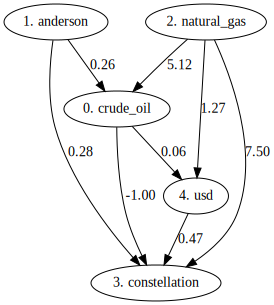

In [26]:
dag

### In dowhy, we set those instrumental variables, X and Y

In [27]:
model = CausalModel(data = df_inference,
                        treatment='0. crude_oil',
                        outcome='3. constellation',
                        common_causes=['U'],
                        instrumental_variable = ['1. anderson', '2. natural_gas'],
                        graph=str(dag))

In [28]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                       
──────────────(E[3. constellation|2. natural_gas,1. anderson])
d[0. crudeₒᵢₗ]                                                
Estimand assumption 1, Unconfoundedness: If U→{0. crude_oil} and U→3. constellation then P(3. constellation|0. crude_oil,2. natural_gas,1. anderson,U) = P(3. constellation|0. crude_oil,2. natural_gas,1. anderson)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimation shows that the crude oil will have causal impact on constellation about -0.97

It is quite close to what we had in causal discovery.

In [29]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="frontdoor.two_stage_regression")


print(estimate)

two_stage_regression
Estimation failed! No relevant identified estimand available for this estimation method.


In [30]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression") # for matching, backdoor.distance_matching


print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                       
──────────────(E[3. constellation|2. natural_gas,1. anderson])
d[0. crudeₒᵢₗ]                                                
Estimand assumption 1, Unconfoundedness: If U→{0. crude_oil} and U→3. constellation then P(3. constellation|0. crude_oil,2. natural_gas,1. anderson,U) = P(3. constellation|0. crude_oil,2. natural_gas,1. anderson)

## Realized estimand
b: 3. constellation~0. crude_oil+2. natural_gas+1. anderson
Target units: ate

## Estimate
Mean value: -0.9724012012588332



In [31]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.distance_matching") # for matching and binary, use backdoor.distance_matching


print(estimate)

distance_matching


Exception: Distance Matching method is applicable only for binary treatments

### Now our null hypothesis is made.

We want to refute my null hypothesis and confirm that our hypothesis is well made.

In this process we will refute our model via 3 processes

1. random common cause

2. placebo
3. data subset reduction

If P value is bigger than 0.05, our null hypothesis is accepted.

### Refute 
1. random common cause

In [32]:
res_random = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

2. placebo 

In [33]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

3. data subset reduction

In [34]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

### We get P values a lot bigger than 0.05, so our model is confirmed

The crude oil is showing a causal impact on constellation by about -0.97 which is quite close to what we had in causal discovery (-0.93)